In [1]:
from _SBMMatrix import *
from _FigureJiazeHelper import *
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Circle
from scipy.sparse.linalg import eigs, eigsh
from scipy.linalg import eig
from _CommunityDetect import *
from spectralOperator import BetheHessian
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

%load_ext autoreload
%autoreload 2

In [2]:
# Matplotlib settings

# plt.style.use('seaborn-whitegrid')
plt.rc('figure', figsize=(8, 5))
plt.rc('font', size=16)
plt.rc('font', family='sans-serif')
plt.rcParams['font.sans-serif'] = 'verdana'
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.edgecolor'] = basic_line_color
plt.rcParams['xtick.color'] = basic_line_color
plt.rcParams['ytick.color'] = basic_line_color
plt.rcParams['axes.labelsize'] = 'large'
plt.rcParams['lines.markersize'] = 12

%config InlineBackend.figure_format = 'retina'

# General SBM

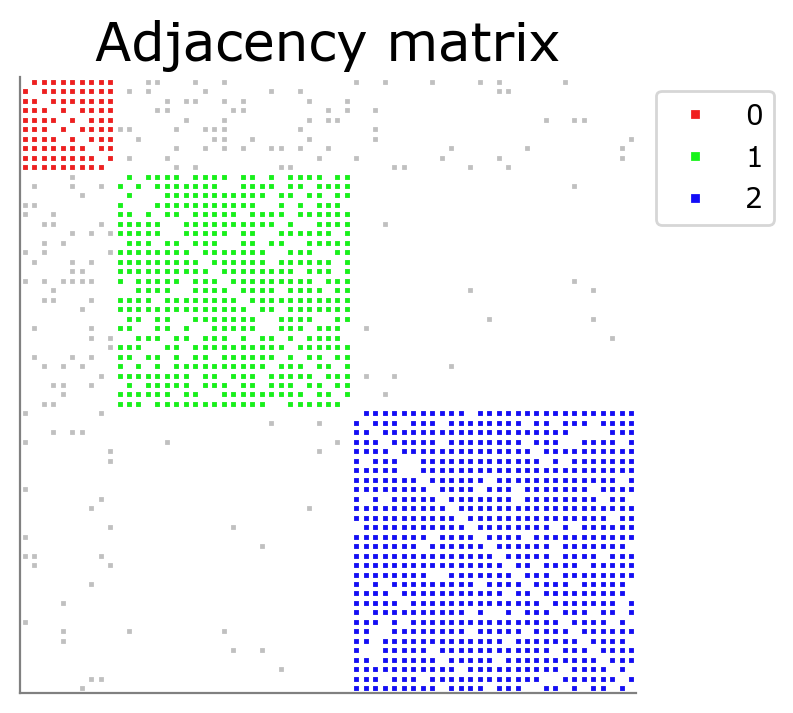

In [58]:
# Any Shape
sizes = [10, 25, 30]
ps = [[0.9, 0.2, 0.1], [0.2, 0.8, 0.02], [0.1, 0.02, 0.9]]
sbm = SBMMatrix(sizes, ps)
d = np.sum(sbm.A) / np.sum(sizes)

fig = plt.figure(figsize=(4, 4))
widths = [4]
heights = [4]
spec5 = fig.add_gridspec(ncols=1, nrows=1, width_ratios=widths, height_ratios=heights)
row = 0
col = 0
ax = fig.add_subplot(spec5[row, col])
c = gen_colors(start=colors_red[0], end=colors_blue[0], n=len(sbm.sizes))
plot_block_matrix(sbm.A.toarray(), partition_names=list(range(len(sbm.sizes))), partition_counts=sbm.sizes, colors=c)

In [14]:
def scatter_spectral(eigvalue, fig=None, ax=None, title='Spectrum'):
    # Construct scatter coordinate
    x = []
    y = []
    for _w in eigvalue:
        _x = _w.real if isinstance(_w, complex) else _w
        _y = _w.imag if isinstance(_w, complex) else 0
        x.append(_x)
        y.append(_y)
    if fig is None and ax is None:
        fig = plt.figure(figsize=(8, 8))
        widths = [4]
        heights = [4]
        spec5 = fig.add_gridspec(ncols=1, nrows=1, width_ratios=widths, height_ratios=heights)
        row = 0
        col = 0
        ax = fig.add_subplot(spec5[row, col])
    plt.axis('equal')
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('data', 0))
    ax.yaxis.set_ticks_position('left')
    ax.spines['left'].set_position(('data', 0))
    ax.scatter(x, y, s=6)
    ax.set_title(title)

In [69]:
def plot_spectral_NBBH(sbm, d):
    print(f'SNR={sbm.get_SNR()}, d={d}')
    NB = sbm.get_operator('NB')
    print(np.shape(NB))
    eig_B, _ = eig(NB.toarray())
    info_eig = []
    for e in eig_B:
        if abs(e) > np.sqrt(d) and e.imag == 0:
            info_eig.append(e)
    print(info_eig)
    fig = plt.figure(figsize=(10, 10))
    widths = [5, 5]
    heights = [5, 5]
    spec5 = fig.add_gridspec(ncols=2, nrows=2, width_ratios=widths, height_ratios=heights)
    row = 0
    col = 0
    ax = fig.add_subplot(spec5[row, col])
    scatter_spectral(eig_B, fig=fig, ax=ax, title="Spectrum of NB")
    ax.add_patch(Circle(xy = (0.0, 0.0), radius=np.sqrt(d), alpha=0.2))

    BH = sbm.get_operator('BH', r=np.sqrt(d))
    eig_BH, _ = eig(BH.toarray())
    info_eig = []
    for e in eig_BH:
        if e < 0:
            info_eig.append(e)
    print(info_eig)
    row = 0
    col = 1
    ax = fig.add_subplot(spec5[row, col])
    scatter_spectral(eig_BH, fig=fig, ax=ax, title="Spectrum of BH with pos r")
    
    BH = sbm.get_operator('BH', r=-np.sqrt(d))
    eig_BH, _ = eig(BH.toarray())
    info_eig = []
    for e in eig_BH:
        if e < 0:
            info_eig.append(e)
    print(info_eig)
    row = 1
    col = 1
    ax = fig.add_subplot(spec5[row, col])
    scatter_spectral(eig_BH, fig=fig, ax=ax, title="Spectrum of BH with neg r")

SNR=15.708509588268559, d=23.53846153846154
(1530, 1530)
[(25.1331754522255+0j), (19.408626592334574+0j)]
[-77.40134430791935, -54.78407624192896]


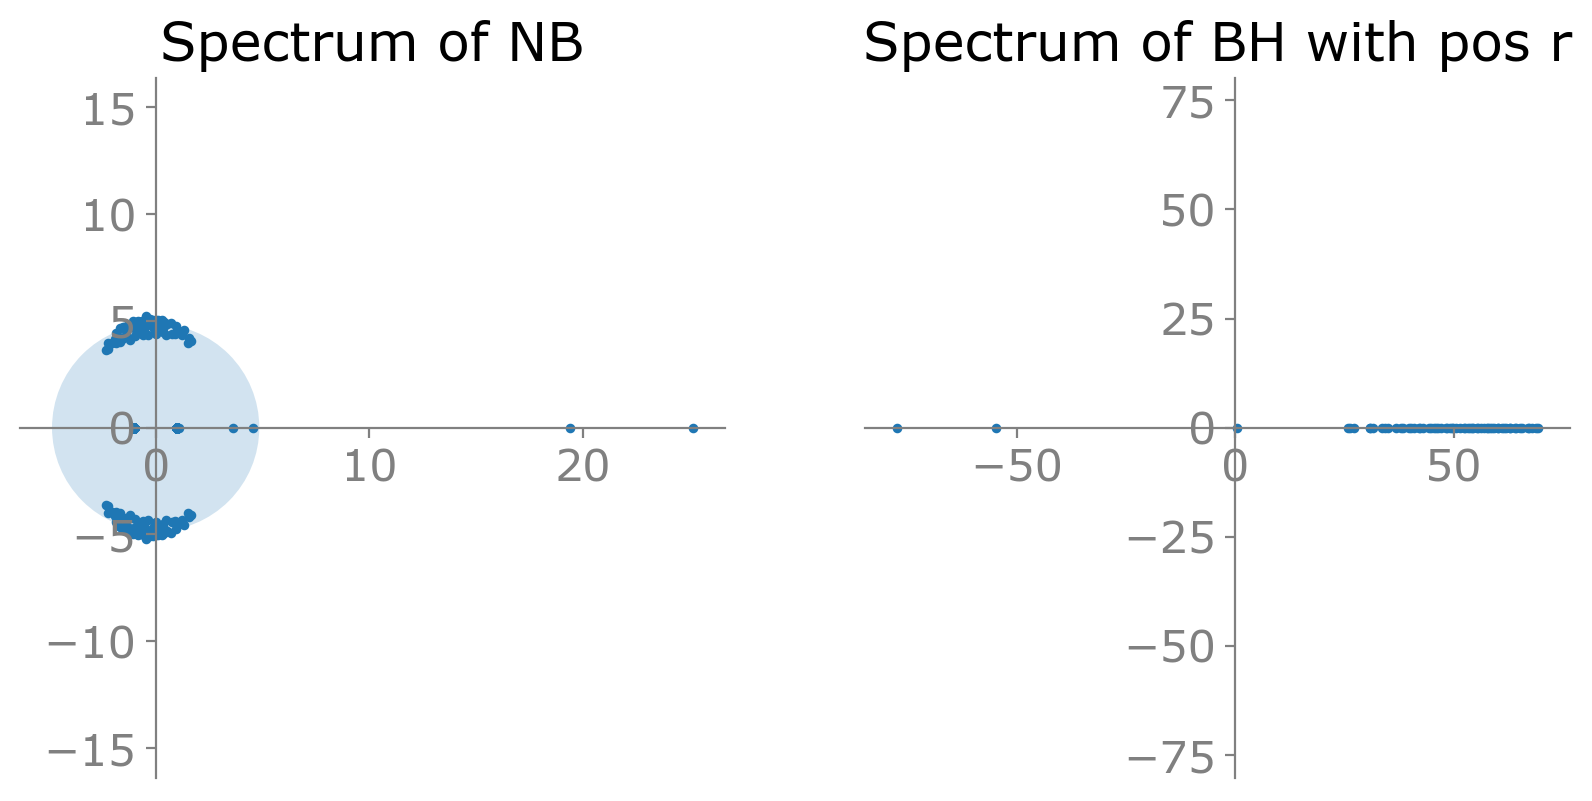

In [59]:
plot_spectral_NBBH(sbm, d)

# SSBM

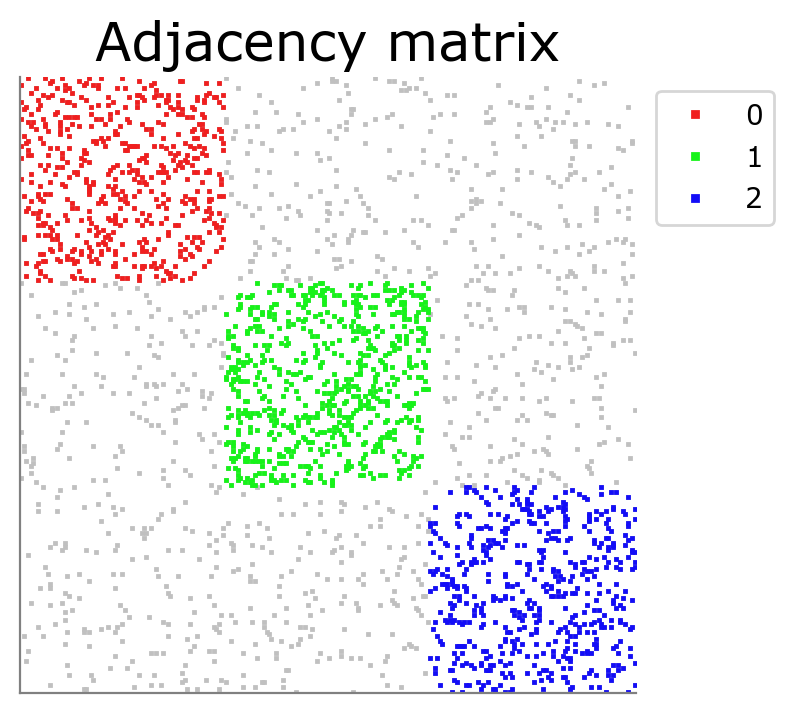

In [60]:
# Symmetric
n = 2**8
k = 3
d = 10
epsilon = 0.3
net = SymmetricSBM.init_epsc(n, k, d, epsilon)

fig = plt.figure(figsize=(4, 4))
widths = [4]
heights = [4]
spec5 = fig.add_gridspec(ncols=1, nrows=1, width_ratios=widths, height_ratios=heights)
row = 0
col = 0
ax = fig.add_subplot(spec5[row, col])
c = gen_colors(start=colors_red[0], end=colors_blue[0], n=len(net.sizes))
plot_block_matrix(net.A.toarray(), partition_names=list(range(len(net.sizes))), partition_counts=net.sizes, colors=c)

SNR=1.9140625, d=10
(2618, 2618)
[(10.165805993945796+0j), (4.873175471357438+0j), (3.4685246582367366+0j)]
[-14.693539946707197, -1.6862878575545892, -0.11389733751078462]


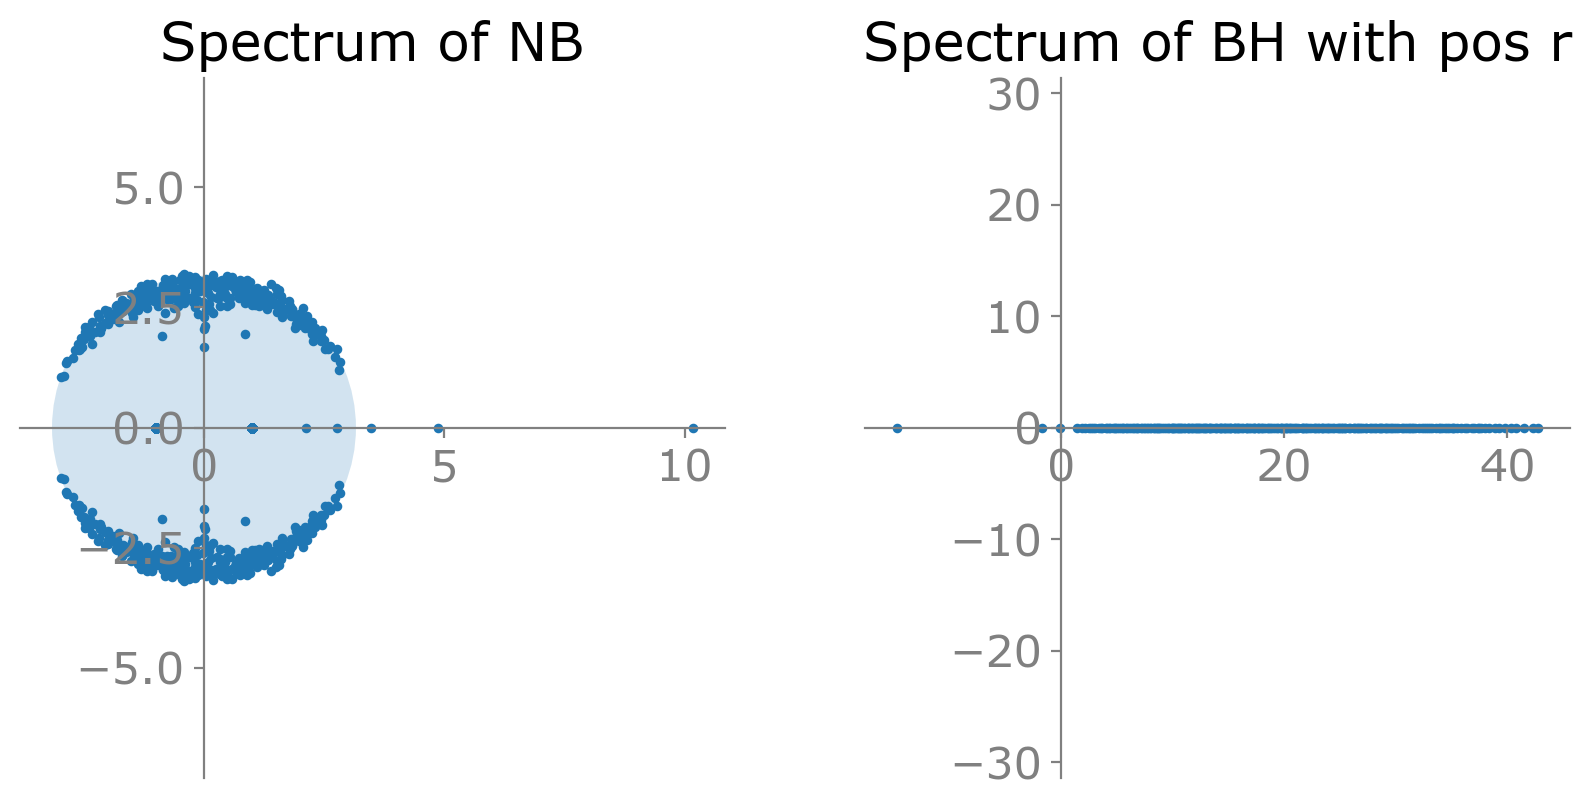

In [61]:
plot_spectral_NBBH(net, d)

# BSBM

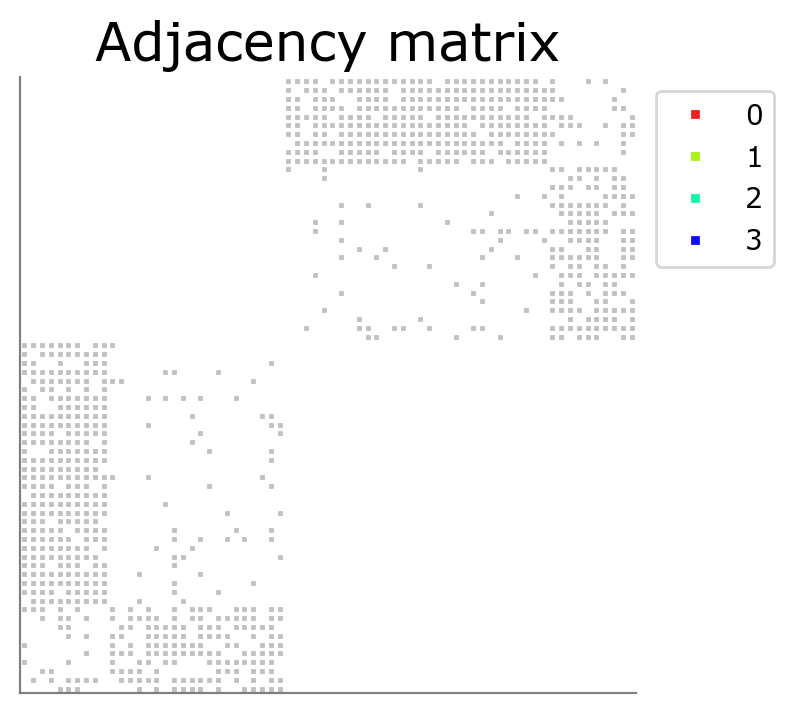

In [66]:
k1 = 2
k2 = 2
sizes = [10, 20, 30, 10]
H = [[0.9, 0.2], [0.1, 0.7]]
sbm = BipartiteSBM(k1, k2, sizes, H)
d = np.sum(sbm.A) / np.sum(sizes)

fig = plt.figure(figsize=(4, 4))
widths = [4]
heights = [4]
spec5 = fig.add_gridspec(ncols=1, nrows=1, width_ratios=widths, height_ratios=heights)
row = 0
col = 0
ax = fig.add_subplot(spec5[row, col])
c = gen_colors(start=colors_red[0], end=colors_blue[0], n=len(sbm.sizes))
plot_block_matrix(sbm.A.toarray(), partition_names=list(range(len(sbm.sizes))), partition_counts=sbm.sizes, colors=c)

SNR=16.3571296279829, d=13.942857142857143
(976, 976)
[(-15.523386262330684+0j), (15.52338626233071+0j), (-7.502375135008538+0j), (7.502375135008517+0j)]
[-30.604940270419036, -7.574984291723715]
[-30.604940270419036, -7.574984291723715]


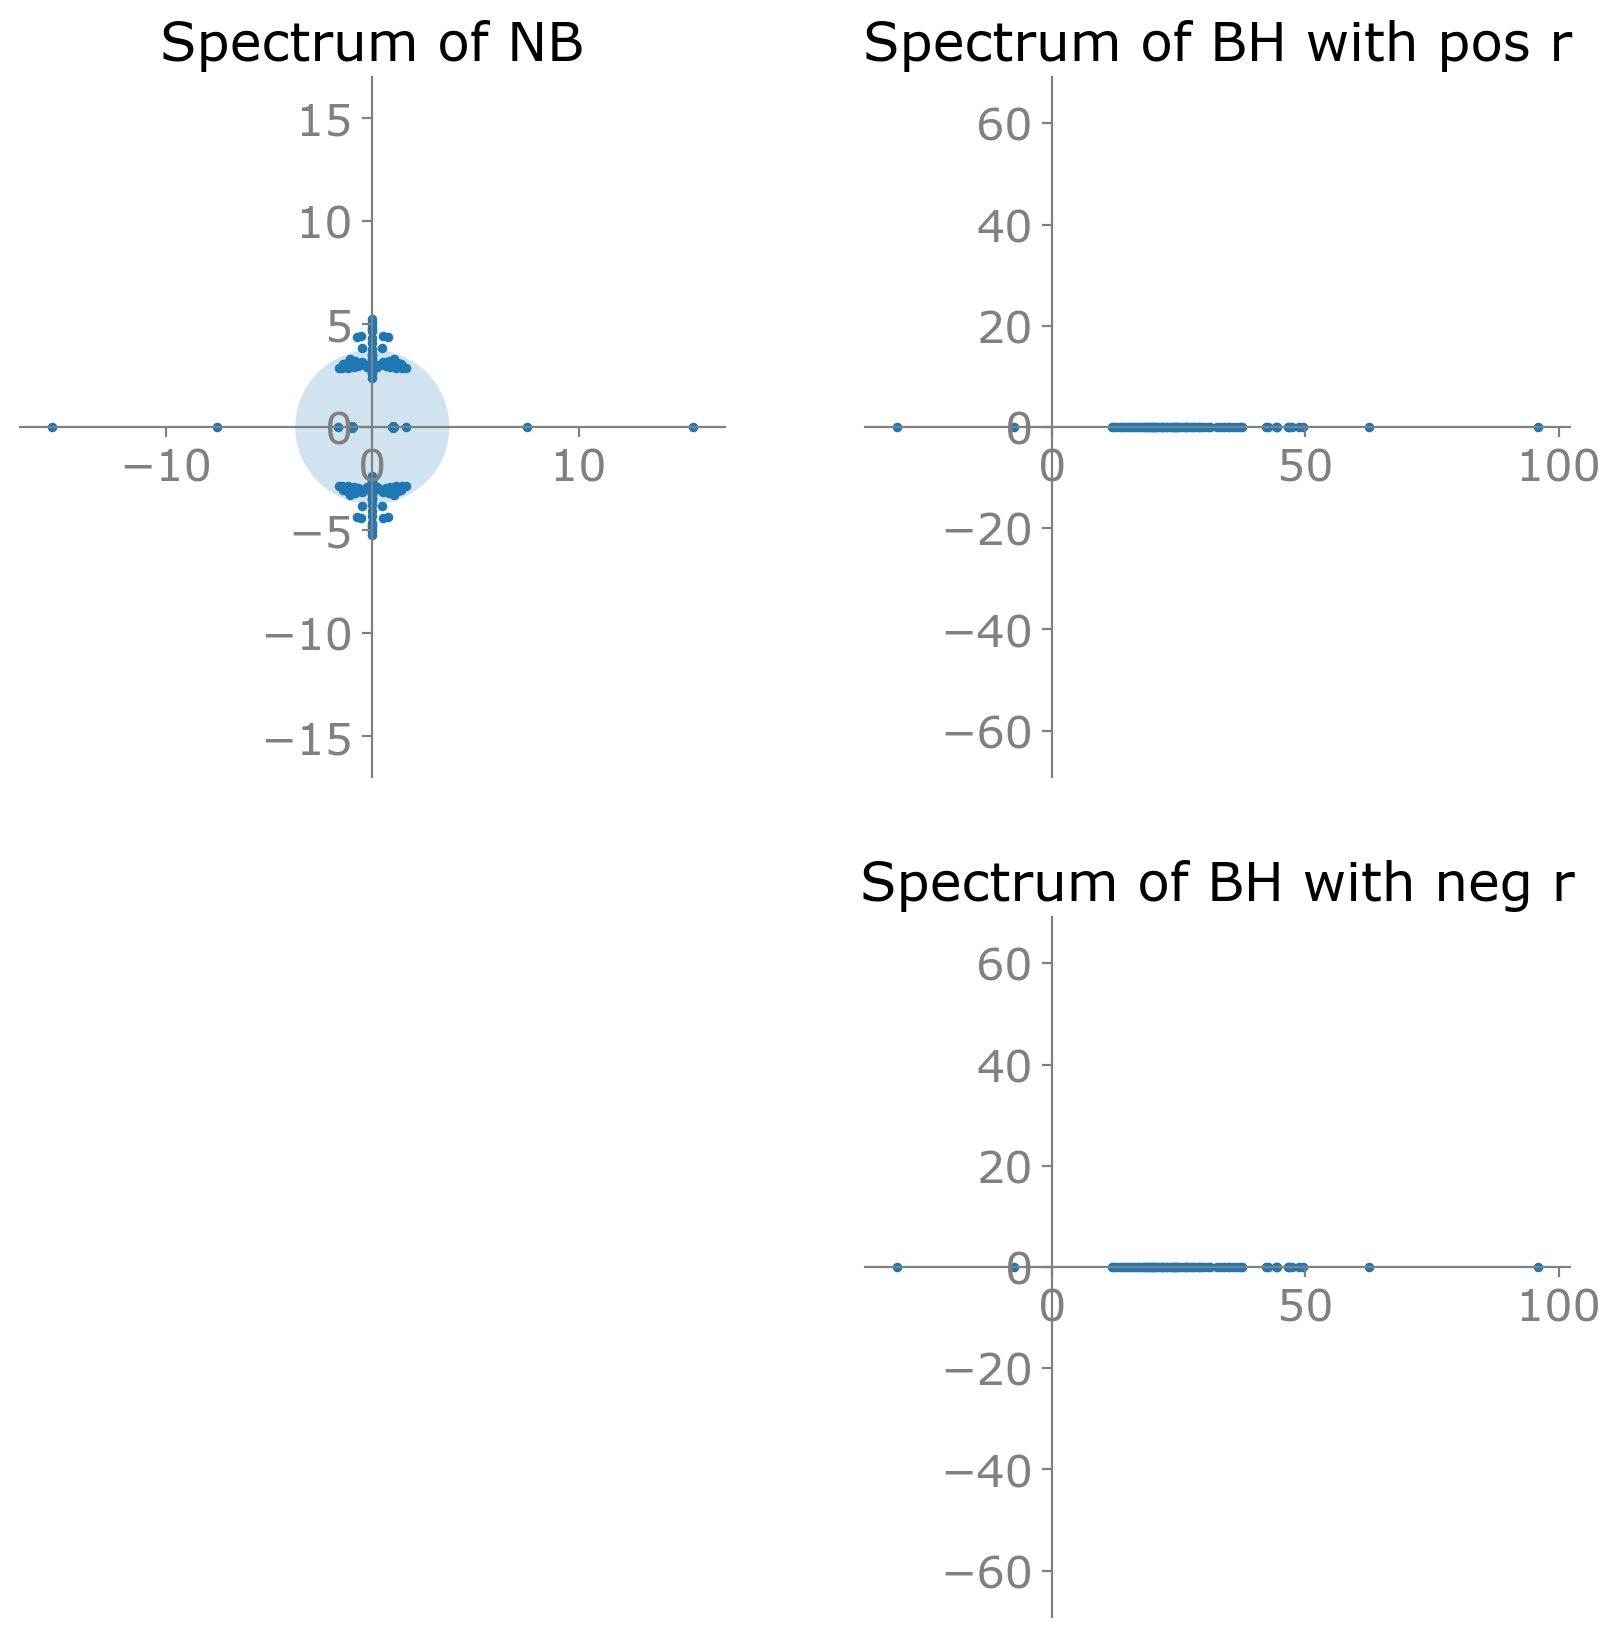

In [70]:
plot_spectral_NBBH(sbm, d)

# Hyper SBM

# of nodes 50, # of edges 421


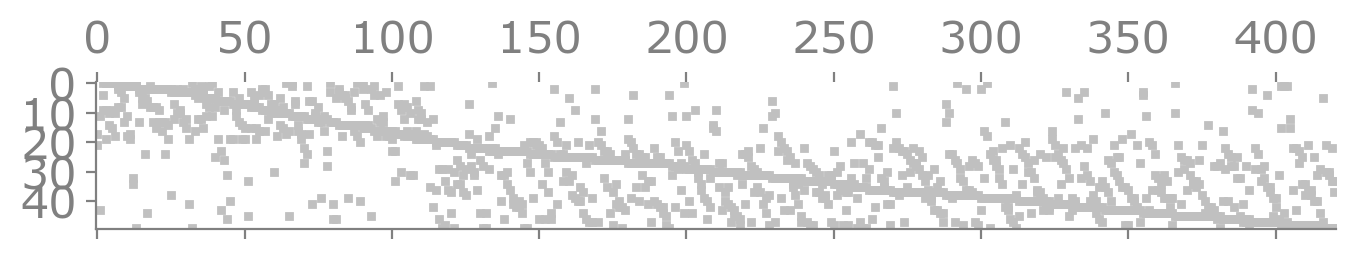

In [25]:
sizes = [20, 30]
ps_dict = {2:[[0.001, 0.001], [0.001, 0.001]], 3:[[[0.01, 0.001], [0.002, 0.001]], [[0.001, 0.001], [0.002, 0.01]]]}
hsbm = HyperSBM(sizes, ps_dict)
print(f'# of nodes {hsbm.n}, # of edges {hsbm.e}')
fig = plt.figure(figsize=(8, 8))
widths = [4]
heights = [4]
spec5 = fig.add_gridspec(ncols=1, nrows=1, width_ratios=widths, height_ratios=heights)
row = 0
col = 0
ax = fig.add_subplot(spec5[row, col])
plt.spy(hsbm.H, markersize=2, rasterized=True, color=gray)

average degree of bipartite form is 5.354564755838641
[(-4.648793525146949+0j), (-2.15848934655564+0j)]
[(-4.648793525146949+0j), (-2.15848934655564+0j)]


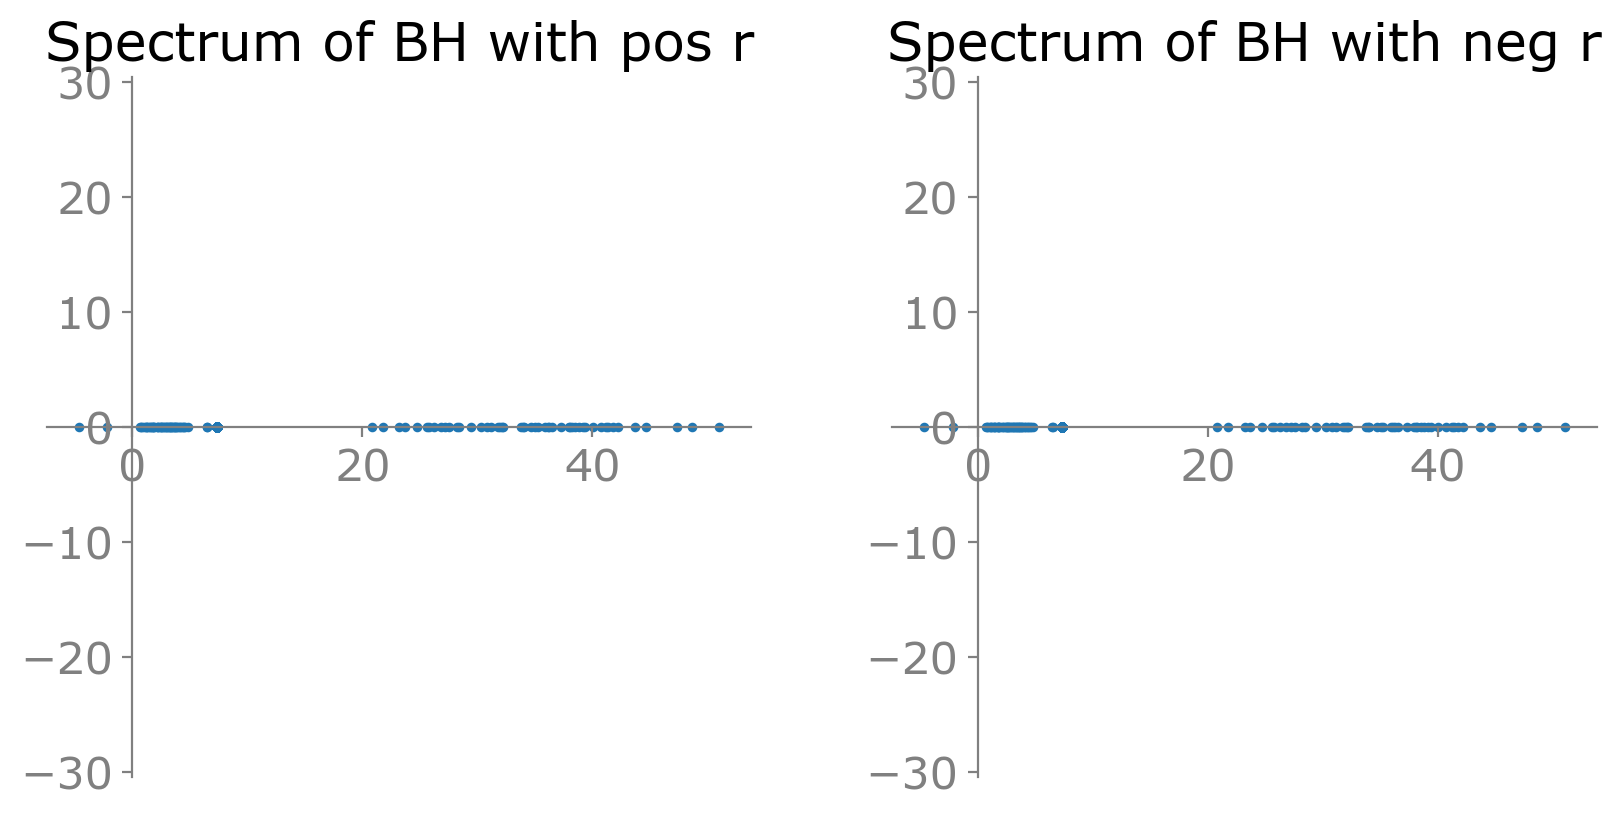

In [26]:
d = np.sum(hsbm.bipartite_A) / (hsbm.n + hsbm.e)
print(f'average degree of bipartite form is {d}')
fig = plt.figure(figsize=(10, 10))
widths = [5, 5]
heights = [5, 5]
spec5 = fig.add_gridspec(ncols=2, nrows=2, width_ratios=widths, height_ratios=heights)
row = 0
col = 0
ax = fig.add_subplot(spec5[row, col])
BH = hsbm.get_operator('BH', r=np.sqrt(d))
eig_BH, _ = eig(BH.toarray())
info_eig = []
for e in eig_BH:
    if e < 0:
        info_eig.append(e)
print(info_eig)
scatter_spectral(eig_BH, fig=fig, ax=ax, title="Spectrum of BH with pos r")

BH = hsbm.get_operator('BH', r=-np.sqrt(d))
eig_BH, _ = eig(BH.toarray())
info_eig = []
for e in eig_BH:
    if e < 0:
        info_eig.append(e)
print(info_eig)
row = 0
col = 1
ax = fig.add_subplot(spec5[row, col])
scatter_spectral(eig_BH, fig=fig, ax=ax, title="Spectrum of BH with neg r")

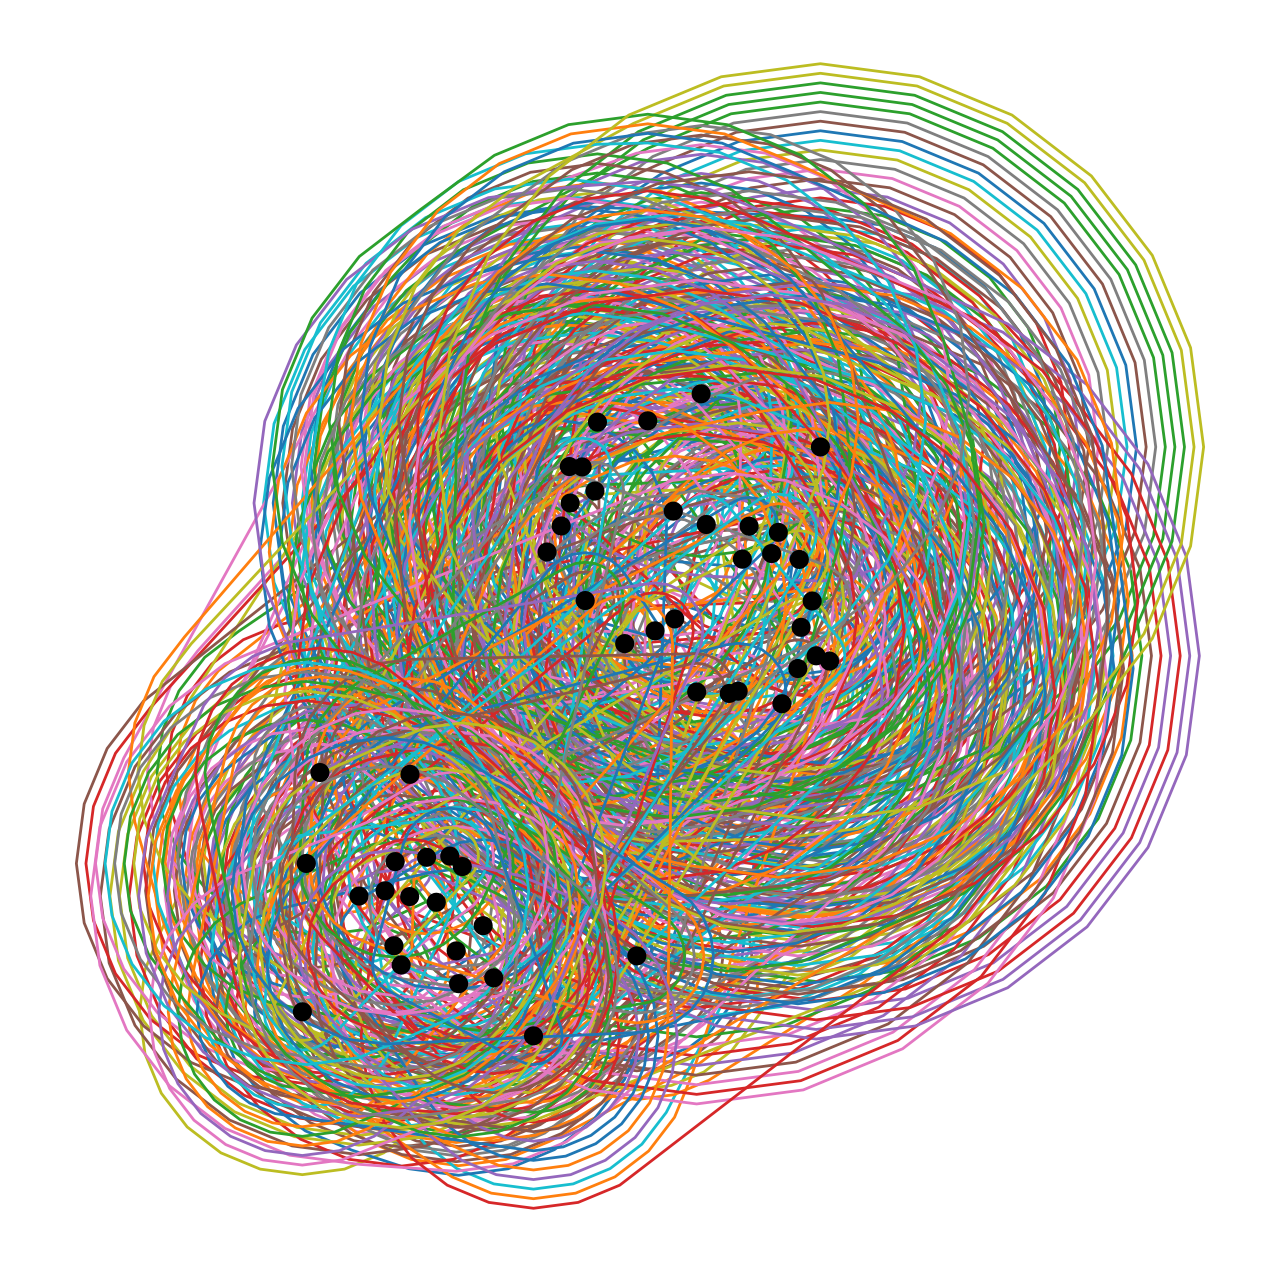

In [27]:
plt.subplots(figsize=(8,8))
hnx.draw(hsbm.hyper_g, with_edge_labels=False, with_node_labels=False)

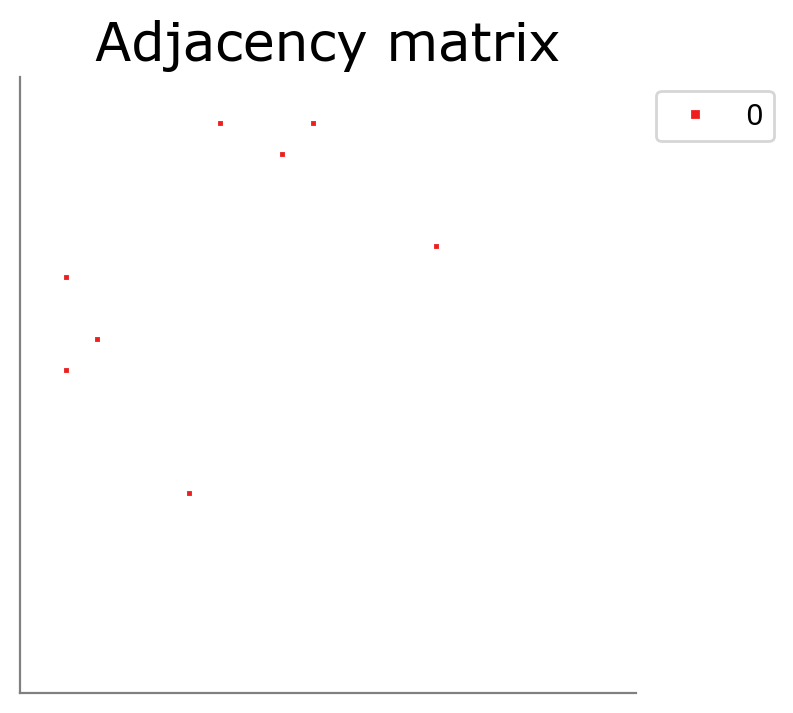

In [15]:
sizes = [20]
ps = [[0.05]]
sbm = SBMMatrix(sizes, ps)
fig = plt.figure(figsize=(4, 4))
widths = [4]
heights = [4]
spec5 = fig.add_gridspec(ncols=1, nrows=1, width_ratios=widths, height_ratios=heights)
row = 0
col = 0
ax = fig.add_subplot(spec5[row, col])
c = gen_colors(start=colors_red[0], end=colors_blue[0], n=len(sbm.sizes))
plot_block_matrix(sbm.A, partition_names=list(range(len(sbm.sizes))), partition_counts=sbm.sizes, colors=c)

In [16]:
fullpartition, full_num_groups = CommunityDetect(sbm.A).BetheHessian()
full_ami = adjusted_mutual_info_score(np.array([0] * np.sum(sizes)), fullpartition)
print(f'Random graph with p={ps[0][0]}, AMI by BH is {full_ami}, detected number of gcommunity is {full_num_groups}')

Input matrix not in sparse format, transforming to sparse matrix
Input matrix not in sparse format, transforming to sparse matrix
number of groups = 32


ValueError: n_samples=20 should be >= n_clusters=32.

pin=0.984375, pout=0.984375


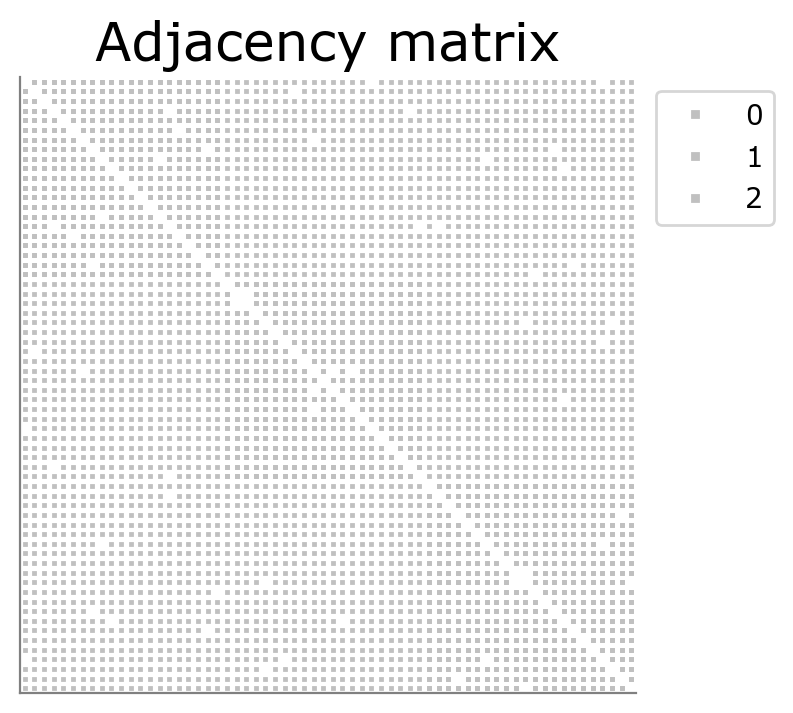

In [23]:
# Symmetric
n = 2**6
k = 3
d = n-1
epsilon = 1
net = SymmetricSBM.init_epsc(n, k, d, epsilon)

fig = plt.figure(figsize=(4, 4))
widths = [4]
heights = [4]
spec5 = fig.add_gridspec(ncols=1, nrows=1, width_ratios=widths, height_ratios=heights)
row = 0
col = 0
ax = fig.add_subplot(spec5[row, col])
c = gen_colors(start=gray, end=gray, n=len(net.sizes))
plot_block_matrix(net.A.toarray(), partition_names=list(range(len(net.sizes))), partition_counts=net.sizes, colors=c)

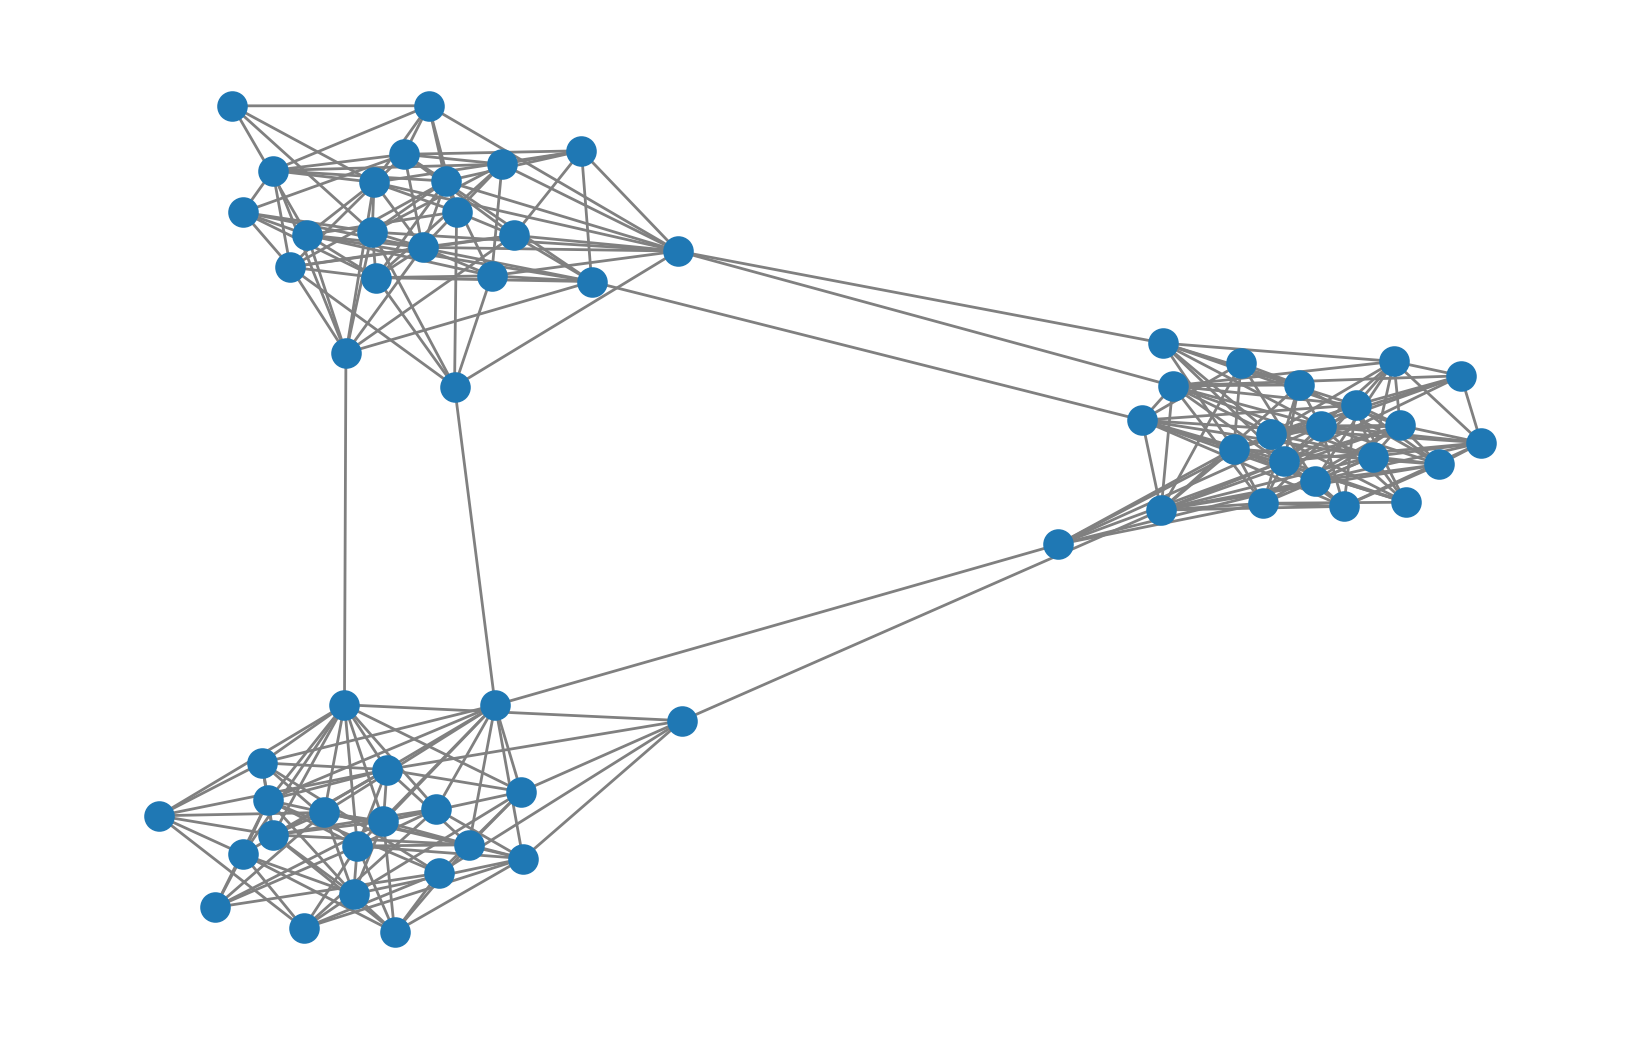

In [19]:
node_color='#1f78b4'
pos = nx.spring_layout(net.g)
nx.draw(net.g, pos=pos, node_size=100, node_color=node_color, edge_color="gray")

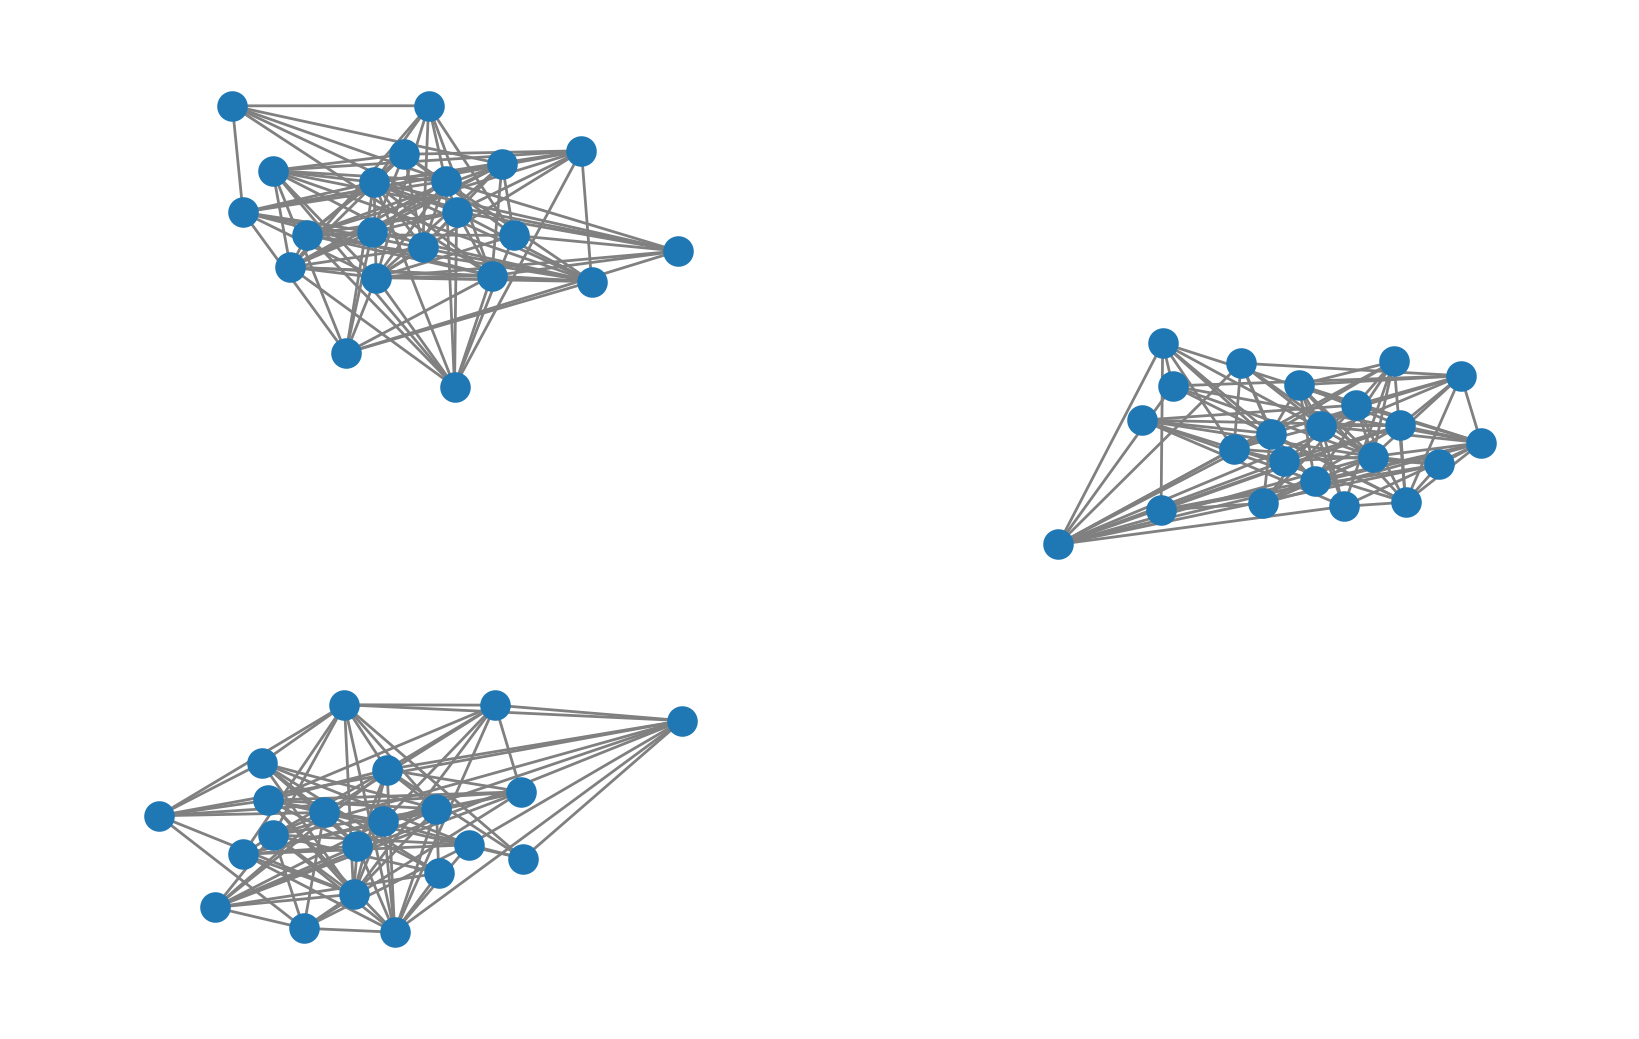

In [21]:
nx.draw(net.g, pos=pos, node_size=100, node_color=node_color, edge_color="gray")

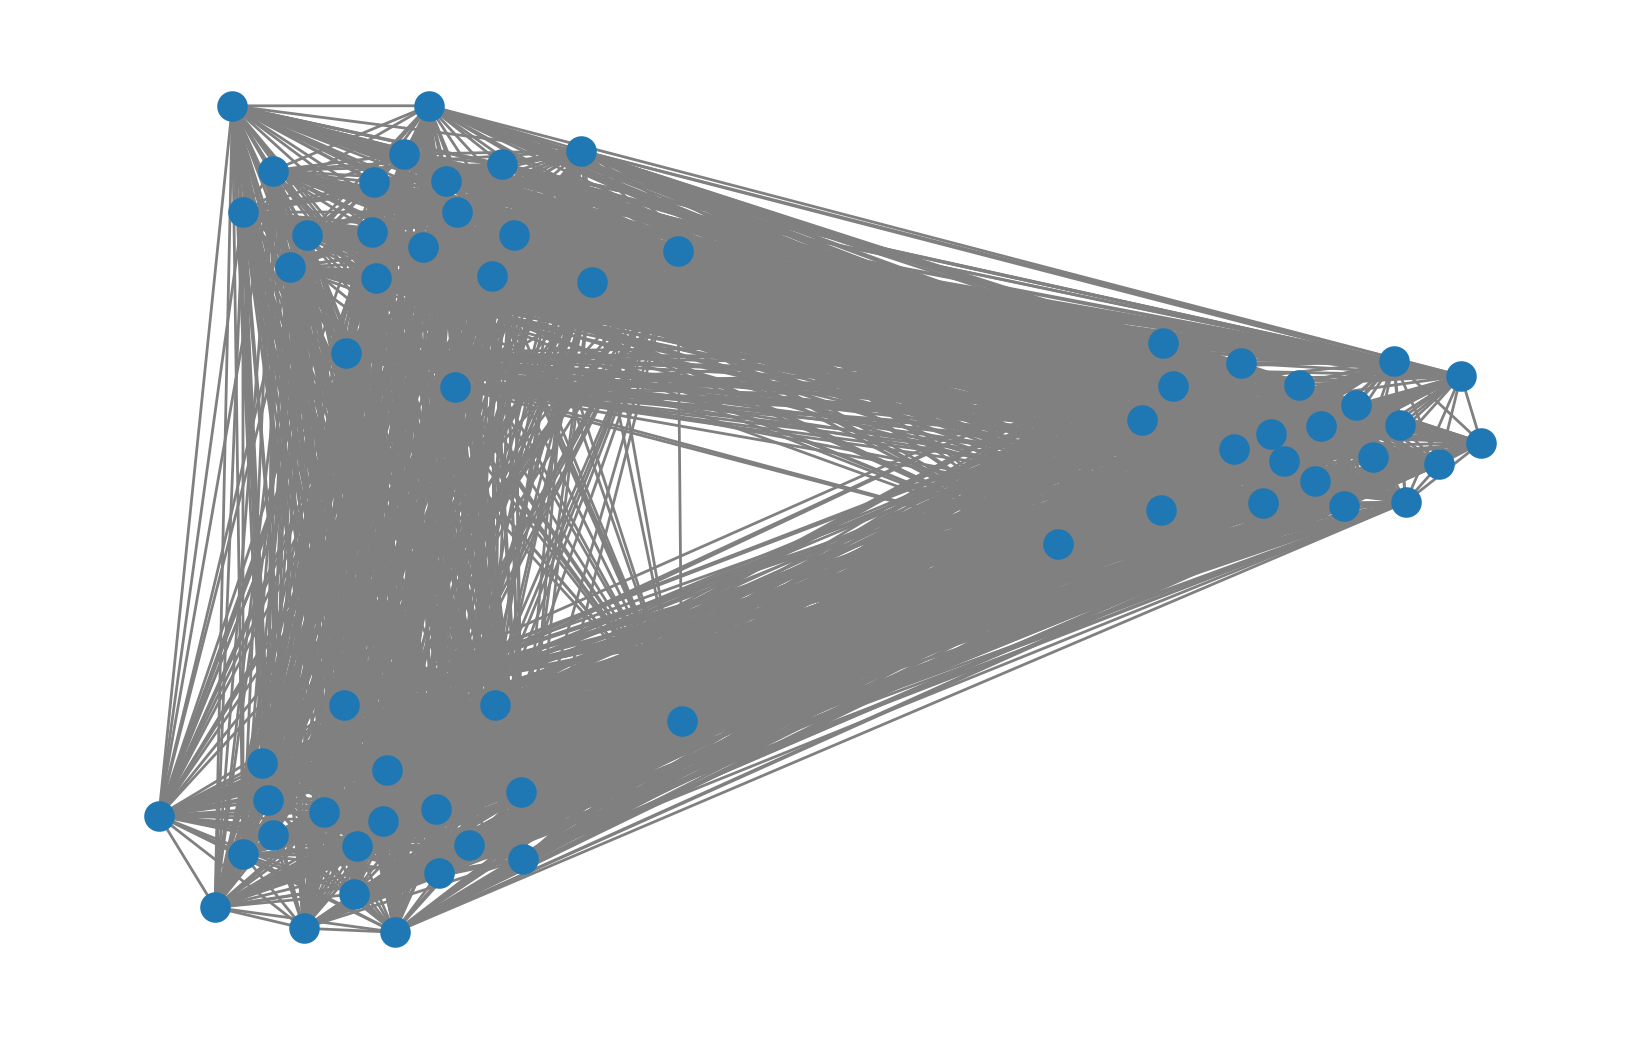

In [24]:
nx.draw(net.g, pos=pos, node_size=100, node_color=node_color, edge_color="gray")

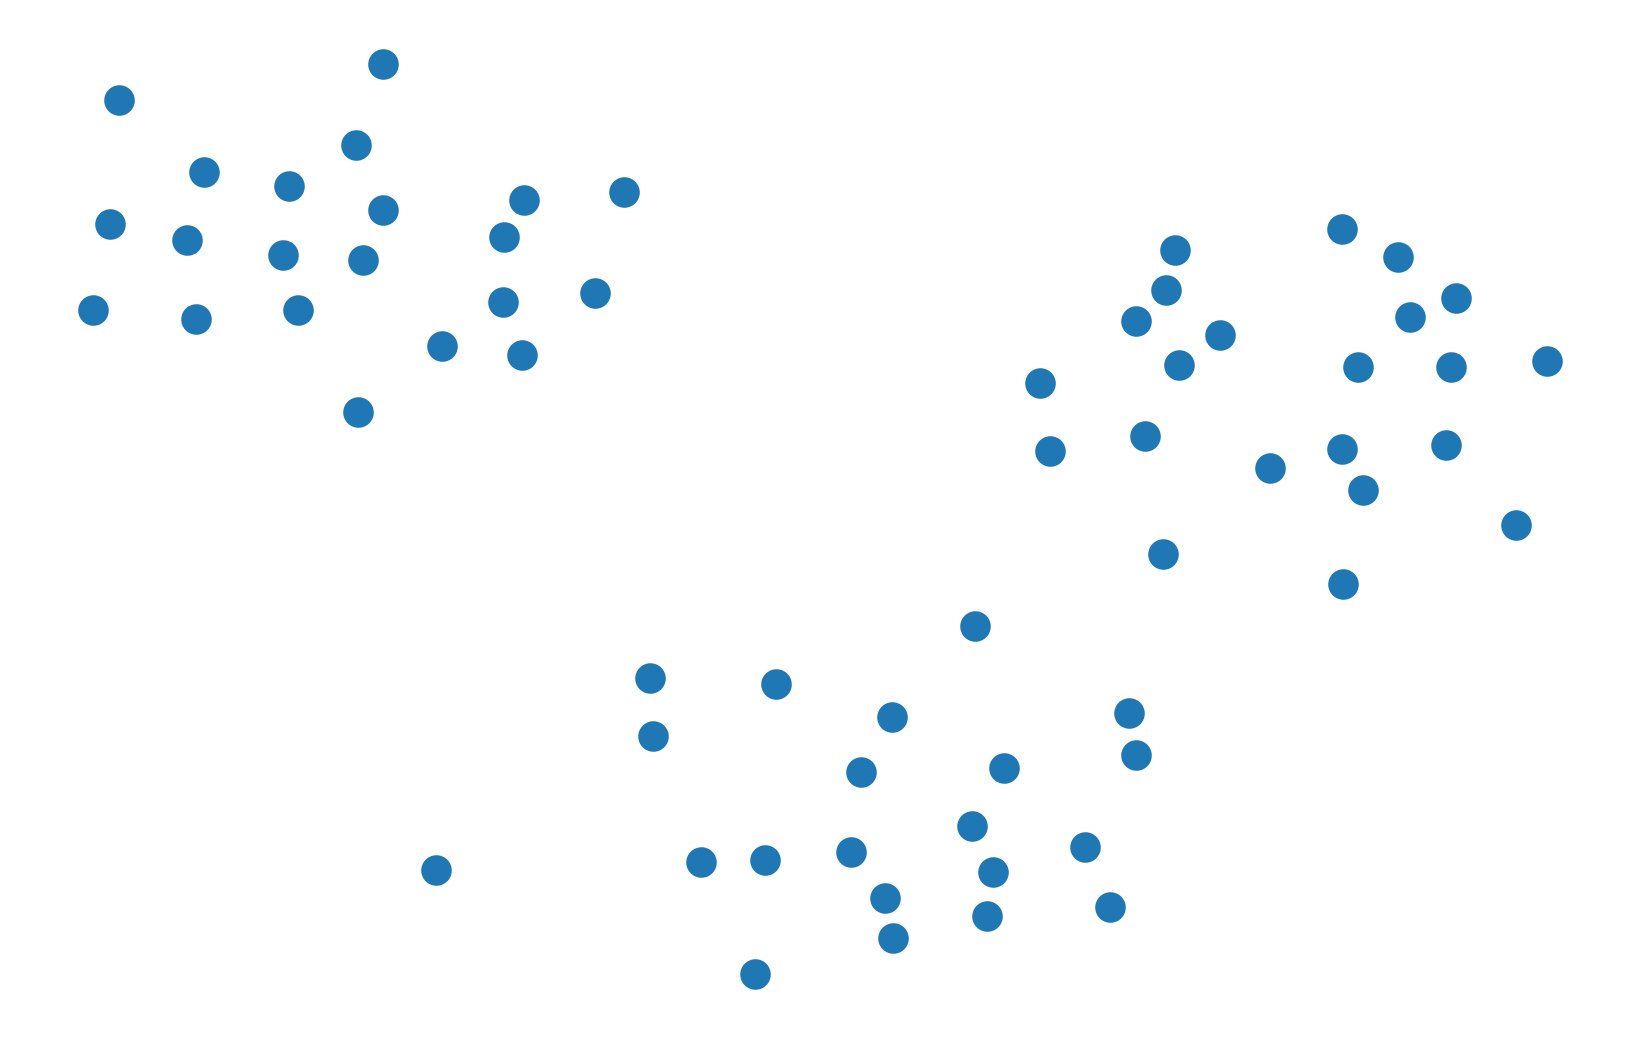

In [27]:
nx.draw(net.g, pos=pos, node_size=100, node_color=node_color, edge_color="gray")